<a href="https://colab.research.google.com/github/SampatPolireddi/ML_Projects/blob/main/3cnn_music_genre_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt 
import os
import math
import json
import scipy.io.wavfile as wavfile
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

Preparing Dataset

Add a diag of our folder structure here for better understanding

In [ ]:
#num_segements are req for the following reasons
#Since to train a ml model we need huge dataset, to achieve that we are further divinding each audio file into 10 segements
#By doing this we can further improve the accuracy of our models
#3 seconds

In [ ]:
dataset_path='/content/drive/MyDrive/music_df/Data/genres_original'
json_path='/content/drive/MyDrive/music_df/Data/data_new.json'
sample_rate= 22050
duration = 30 #(seconds) #track duration
num_of_samples_per_track = sample_rate * duration


def storing_mfcc_data(dataset_path,json_path,num_mfcc=13,n_fft=2048,hop_length=512,num_segments=10):
  
  
  #'data' is a dictionary to store our audio files in the text format
  data={
      'genre_names': [], #contains names of different genres
      'mfcc':[], #contains the mfcc values of each audio track for each genre
      'labels':[] # The 10 generes are mapped from 0 to 9
  }

  num_of_samples_per_segment =int(num_of_samples_per_track/num_segments)
  expected_num_mfcc_vectors_per_segment=math.ceil(num_of_samples_per_segment/hop_length)

  #for loop to navigate through all the sub-folders in our dataset path
  for i,(directory_path,directory_names,file_names) in enumerate(os.walk(dataset_path)): #directory_path(current_folder)->directory_names(sub-folders in directory_path)->file_names(all the audio files in the sub-folder)
     
    #i is the current count, which is required to assign labels to each genre
    #'os.walk' in the 1st itr will give the data set path as output, and not the subfolders
    #Making sure that the loop is in the sub-folder                                                                                    
    if directory_path != dataset_path:

      #Step 1: Storing the genre names in the 'genre_names' list
      directory_path_name=directory_path.split('/') # directory_path=genre_original/classical
                                                    #By splitting we get, 'directory_path_name'=['genre_original','classical']
      semantic_label=directory_path_name[-1]  #Assigning 'semantic_label' to the last comp in 'directory_path_name'
      data["genre_names"].append(semantic_label) #Storing the value in 'genre_names'
      

      #Step 2: Load mfcc data to 'mfcc' list
      for f in file_names:
         
        #Loading the audio file
        file_path=os.path.join(directory_path,f) # filepath= genre_original/classical+ classical.00000.wav =>genre_original/classical/classical.00000.wav
        signal,sr= librosa.load(file_path,sr=sample_rate) #sr=>sample_rate
        
        #Processing the audio files into multiple segments and extracting mfcc
        for s in range(num_segments):
          starting_sample=num_of_samples_per_segment*s
          finishing_sample=starting_sample+ num_of_samples_per_segment
        
          #Extracting mfcc
          mfcc = librosa.feature.mfcc(signal[starting_sample:finishing_sample], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
          mfcc = mfcc.T
          
          #Storing the mfcc
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist()) #Converting the mfcc to list and storing it in 'mfcc' list
            data["labels"].append(i-1) #i-1 because, earlier we ignored i=0 since the first itr will give the data_set path of the main folder itself
                                       #Since we assigning label values from 0 to 9, we do i-1
            print("{}, segment:{}".format(file_path, s+1))
          
  #Storing the data aquired in json format
  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)

storing_mfcc_data(dataset_path, json_path, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/music_df/Data/genres_original/blues/blues.00099.wav, segment:8
/content/drive/MyDrive/music_df/Data/genres_original/blues/blues.00099.wav, segment:9
/content/drive/MyDrive/music_df/Data/genres_original/blues/blues.00099.wav, segment:10
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:1
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:2
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:3
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:4
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:5
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:6
/content/drive/MyDrive/music_df/Data/genres_original/classical/classical.00001.wav, segment:7
/content/drive/MyDrive/music_df/

In [ ]:
#Func to read n values in a dict
# from itertools import islice

# def take(n, iterable):
#     "Return first n items of the iterable as a list"
#     return list(islice(iterable, n))

# take(5,data['mapping'])

Neural Network

In [ ]:
json_dataset_path="/content/drive/MyDrive/music_df/Data/data_new.json"

def data(json_dataset_path): #Loading our data to use it in our model
  with open(json_dataset_path,'r') as fp:
    data=json.load(fp)

  #Since in our data, the mfcc values and the labels will be assumed as lists.
  #Hence we convert them into numpy arr
  x=np.array(data['mfcc'])
  y=np.array(data['labels'])

  return x, y

x,y =data(json_dataset_path)

In [ ]:
print("The no.of dimensions in the arr 'x' =",x.ndim)
#index 0 => diff tracks
#index 1 => diff intervals(since we divided our track into n segments)
#index 2 => values of the mfccs for that interval

The no.of dimensions in the arr 'x' = 3


In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25)

CNN

In [ ]:
X, y = data(json_dataset_path)

#splitting data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

#adding an axis to input sets, since we need an 3d array, currently we have a 2d array
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
model = keras.Sequential()

#convolutional layers
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1),padding='valid'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu',padding='valid'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu',padding='valid'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
#model.add(keras.layers.Conv2D(512, (4, 4), activation='relu',padding='valid'))
model.add(keras.layers.BatchNormalization())


#flattening the output and feeding it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))

#output layer
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 256)      2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 9, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 5, 256)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 3, 256)        590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 256)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 31, 2, 256)       1

In [ ]:
#training
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
175/175 [==============================] - 593s 3s/step - loss: 1.3774 - accuracy: 0.5106 - val_loss: 1.3047 - val_accuracy: 0.5386
Epoch 2/30
175/175 [==============================] - 585s 3s/step - loss: 0.9224 - accuracy: 0.6726 - val_loss: 1.5863 - val_accuracy: 0.5043
Epoch 3/30
175/175 [==============================] - 592s 3s/step - loss: 0.6578 - accuracy: 0.7740 - val_loss: 1.1639 - val_accuracy: 0.6130
Epoch 4/30
175/175 [==============================] - 592s 3s/step - loss: 0.4258 - accuracy: 0.8614 - val_loss: 0.9283 - val_accuracy: 0.6803
Epoch 5/30
175/175 [==============================] - 584s 3s/step - loss: 0.2553 - accuracy: 0.9256 - val_loss: 0.8993 - val_accuracy: 0.7132
Epoch 6/30
175/175 [==============================] - 579s 3s/step - loss: 0.1614 - accuracy: 0.9592 - val_loss: 0.9043 - val_accuracy: 0.7160
Epoch 7/30
175/175 [==============================] - 585s 3s/step - loss: 0.0847 - accuracy: 0.9834 - val_loss: 0.8264 - val_accuracy: 0.7496

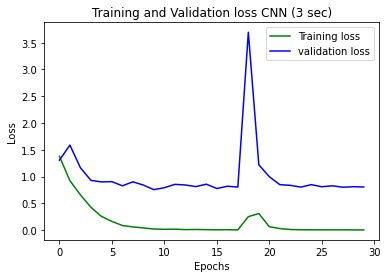

In [ ]:
import pandas as pd

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss CNN (3 sec)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

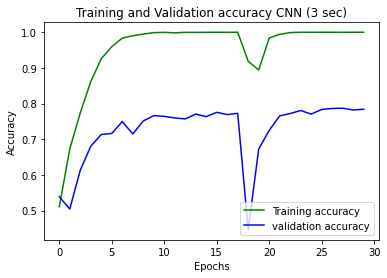

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy CNN (3 sec)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

RNN-LSTM

In [ ]:
model = keras.Sequential()

#layers of LSTM(2)
model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(64))

#dense layer
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))

#output layer
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

#training
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
175/175 [==============================] 

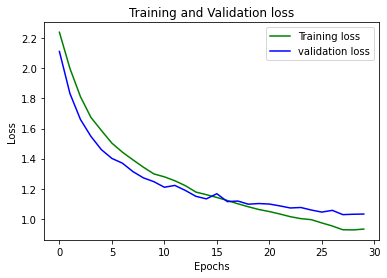

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

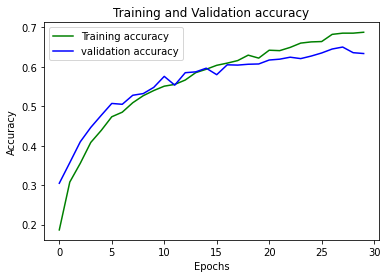

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()